In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing

In [11]:
#getting the dataset
cal_housing = fetch_california_housing()
X = pd.DataFrame(cal_housing.data, columns=cal_housing.feature_names)
Y = cal_housing.target
df = pd.DataFrame(
    dict(MedInc=X['MedInc'], Price=cal_housing.target, HouseAgeGroup=(X['HouseAge'].values / 10).astype(np.int)))
X = df['MedInc']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


İlk olarak problemin aslında bir 'minimize the maximum' problemi olduğunu düşündüm ve araştırınca bu problem
      için aslında Minkowski L-infinity norm kullanılabileceğini gördüm. Yani aslında minimize max {|y-y_pred|}. Ama
      bu problemi gradient descentte kullanmak için matematiğini araştırınca istediğim sonuca ulaşamadım ve
      matematiğini anlamadığım bir model implement etmek istemedim.

Problemi biraz daha basitleştirmek istedim ve belli bir thresholdun üzerindeki losslar için L-4 Norm loss function
      kullanırken, küçük losslar için L-1 norm loss function kullandım.

İş birimleri ile bir sonraki toplantıda orta yol olarak belli bir thresholdun altındaki lossların toplam lossa 
etkisinin oldukça az olacağı bir model tasarladığımızı söyleyebiliriz.

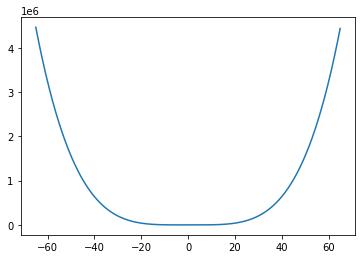

In [12]:
# Plotting the convexity
x_vals = np.arange(-65, 65, 0.1)
y_vals = []


for i in range(len(x_vals)):
    if np.abs(x_vals[i]) <= 1.5:
        y_vals.append(1.5 * (np.abs(x_vals[i]) - 0.5 * 1.5))
    else:
        y_vals.append(0.25*(x_vals[i])**4)

plt.plot(x_vals, y_vals)
plt.show()

In [13]:
# defining the linear regression function
def lr(x, y, lam, alpha=0.001, delta=10, max_iter=1000) -> np.ndarray:
    beta = np.random.random(2)

    print("starting sgd")
    for i in range(max_iter):
        y_pred: np.ndarray = beta[0] + beta[1] * x

        if (y-y_pred).sum()/len(y) > delta:
            g_b0 = -1 * ((y - y_pred)**3).sum()
            g_b1 = -1 * ((x * (y - y_pred))**3).sum()
        else:
            g_b0 = -1*delta*((y-y_pred)/(np.abs(y-y_pred))).sum()
            g_b1 = -1*beta[1]*delta*((y-y_pred)/(np.abs(y-y_pred))).sum()

        print(f"({i}) beta: {beta}, gradient: {g_b0} {g_b1}")

        beta_prev = np.copy(beta)

        beta[0] = beta[0] - alpha * g_b0 + 2 * lam * beta[0]
        beta[1] = beta[1] - alpha * g_b1 + 2 * lam * beta[1]

        if np.linalg.norm(beta - beta_prev) < 0.001:
            print(f"I do early stopping at iteration {i}")
            break

    return beta

In [14]:
# the model from wedo_1
def reg(x, y, group, p=0.3, verbose=False):
    beta = np.random.random(2)
    gamma = dict((k, np.random.random(2)) for k in range(6))

    alpha = 0.002
    n_max_iter = 100
    for it in range(n_max_iter):

        err = 0
        for _k, _x, _y in zip(group, x, y):
            y_pred = p * (beta[0] + beta[1] * _x) + (1 - p) * (gamma[_k][0] + gamma[_k][1] * _x)

            g_b0 = -2 * p * (_y - y_pred)
            g_b1 = -2 * p * ((_y - y_pred) * _x)

            g_g0 = -2 * (1 - p) * (_y - y_pred)
            g_g1 = -2 * (1 - p) * ((_y - y_pred) * _x)

            beta[0] = beta[0] - alpha * g_b0
            beta[1] = beta[1] - alpha * g_b1

            gamma[_k][0] = gamma[_k][0] - alpha * g_g0
            gamma[_k][1] = gamma[_k][1] - alpha * g_g1

            err += (_y - y_pred) ** 2

        # print(f"{it} - Beta: {beta}, Gamma: {gamma}, Error: {err}")

    return beta, gamma

In [15]:
#calling the function and getting beta values
final_beta = lr(df['MedInc'], Y, lam=0.001, alpha=10**-8, delta=20, max_iter=2000)
print("My model's beta values: ", final_beta)

#prediction and finding the loss
y_p = final_beta[0] + final_beta[1]*df['MedInc']
loss = ((Y - y_p)**2).sum()/len(Y)
print("My model's loss: ", loss)

starting sgd
(0) beta: [0.8899301  0.85957558], gradient: 386280.0 332036.8532366633
(1) beta: [0.88784716 0.85797436], gradient: 385960.0 331143.78319191205
(2) beta: [0.88576325 0.85637887], gradient: 385400.0 330048.41604614496
(3) beta: [0.88368078 0.85479114], gradient: 385240.0 329299.7397000106
(4) beta: [0.88159574 0.85320773], gradient: 385000.0 328484.97500764014
(5) beta: [0.87950893 0.85162929], gradient: 384720.0 327638.8216018368
(6) beta: [0.87742075 0.85005616], gradient: 384400.0 326761.5891982965
(7) beta: [0.87533159 0.84848866], gradient: 384240.0 326023.28264224646
(8) beta: [0.87323986 0.8469254 ], gradient: 384080.0 325287.1092816192
(9) beta: [0.87114554 0.84536638], gradient: 383880.0 324519.24749405147
(10) beta: [0.86904903 0.84381192], gradient: 383680.0 323753.7591168986
(11) beta: [0.86695033 0.84226201], gradient: 383480.0 322990.6358100404
(12) beta: [0.86484943 0.84071663], gradient: 383200.0 322162.6119355534
(13) beta: [0.86274713 0.83917644], gradien

In [16]:
wedo_beta, wedo_gamma = reg(df['MedInc'].values, df['Price'].values, df['HouseAgeGroup'].values)
wedo_pred = wedo_beta[0] + wedo_beta[1]*df['MedInc']
wedo_loss = ((Y - wedo_pred)**2).sum()/len(Y)
print("We do loss: ", wedo_loss)

We do loss:  3.326133596572868


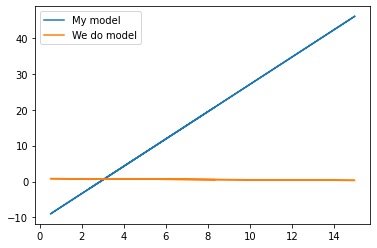

In [17]:
# Plotting the two models together
plt.plot(df['MedInc'], y_p, label="My model")
plt.plot(df['MedInc'], wedo_pred, label="We do model")
plt.legend()
plt.show()